# **1. Import & Setup**

This section handles the initial environment configuration, including library installations, imports, and visualization settings. We configure matplotlib with custom fonts (Poppins) and establish a consistent color scheme for all visualizations throughout the analysis.

## **1.1 Library Installation**

In [ ]:
pip install Sastrawi

## **1.2 Library Import**

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Standard Library
import time
import re
import json
import warnings
from datetime import datetime
from collections import Counter

warnings.filterwarnings('ignore')

# Numerical & Data Handling
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.interpolate import make_interp_spline

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager as fm, dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud

# Utilities
import joblib
from sklearn.utils.class_weight import compute_class_weight

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## **1.3 Configuration & Settings**

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

mpl.rcParams['boxplot.boxprops.color'] = '#808080'
mpl.rcParams['boxplot.capprops.color'] = '#808080'
mpl.rcParams['boxplot.whiskerprops.color'] = '#808080'
mpl.rcParams['boxplot.medianprops.color'] = '#808080'
mpl.rcParams['boxplot.flierprops.color'] = '#808080'
mpl.rcParams['boxplot.meanprops.color'] = '#808080'

# **2. Data Loading**

This section loads the Telegram reviews dataset and performs initial data inspection. We examine the dataset structure, generate basic statistics, and create derived features such as text length categories and sentiment labels based on ratings.

## **2.1 Load Dataset**

In [ ]:
df = pd.read_csv('ulasan_org.telegram.messenger.csv')
display(df.head())

,Nama User,Ulasan,Rating,Tanggal,Likes,Versi App
0,Pengguna Google,emng ga cocok aja di aku krna aku gratisan,1,2025-12-31 17:50:01,0,12.2.11
1,Pengguna Google,mantap,5,2025-12-31 17:21:01,0,NaN
2,Pengguna Google,gak bisa masuk jelek baget mending gak usah bikin apk kayak gini kalok bisa ku kasih bitang0 jelek bagetttttttt,1,2025-12-31 17:05:08,0,NaN
3,Pengguna Google,"kenapa intagram harus kepremium ,padahal baru install",1,2025-12-31 16:42:29,0,12.2.11
4,Pengguna Google,"gak bangetttt, masa mau login aja harus bayarr, ini emang davelopernya yang kikir atau gimana sih, gak banget serius",1,2025-12-31 16:25:59,0,NaN


## **2.2 Basic Info & Statistics**


In [ ]:
# Define length categories
def length_category(x):
    if x <= 5:
        return 'Short'
    elif x <= 15:
        return 'Medium'
    else:
        return 'Long'

df['Text_Length'] = df['Ulasan'].astype(str).apply(lambda x: len(x.split()))
df['Length_Category'] = df['Text_Length'].apply(length_category)

In [ ]:
print("Dataset Shape:", df.shape)
print("\nDataset Information:")
df.info()

Dataset Shape: (100000, 8)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Nama User        100000 non-null  object
 1   Ulasan           100000 non-null  object
 2   Rating           100000 non-null  int64 
 3   Tanggal          100000 non-null  object
 4   Likes            100000 non-null  int64 
 5   Versi App        65994 non-null   object
 6   Text_Length      100000 non-null  int64 
 7   Length_Category  100000 non-null  object
dtypes: int64(3), object(5)
memory usage: 6.1+ MB


In [ ]:
print("Descriptive Statistics:")
display(df.describe(include='all'))

Descriptive Statistics:


,Nama User,Ulasan,Rating,Tanggal,Likes,Versi App,Text_Length,Length_Category
count,100000,100000,100000.000000,100000,100000.000000,65994,100000.000000,100000
unique,999,80131,NaN,99875,NaN,247,NaN,3
top,Pengguna Google,Bagus,NaN,2024-04-26 16:44:24,NaN,10.12.0,NaN,Short
freq,99001,1306,NaN,3,NaN,3651,NaN,42646
mean,NaN,NaN,2.520360,NaN,3.766100,NaN,11.234210,NaN
std,NaN,NaN,1.798916,NaN,102.462109,NaN,12.586957,NaN
min,NaN,NaN,1.000000,NaN,0.000000,NaN,1.000000,NaN
25%,NaN,NaN,1.000000,NaN,0.000000,NaN,3.000000,NaN
50%,NaN,NaN,1.000000,NaN,0.000000,NaN,7.000000,NaN
75%,NaN,NaN,5.000000,NaN,0.000000,NaN,15.000000,NaN


In [ ]:
print("Rating Distribution:")
print(df['Rating'].value_counts())

Rating Distribution:
Rating
1    53296
5    30626
2     6774
3     5154
4     4150
Name: count, dtype: int64


In [ ]:
def classify_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Rating'].apply(classify_sentiment)
print("Sentiment Distribution:")
print(df['Sentiment'].value_counts())
print("\nSentiment Distribution (%):")
print(df['Sentiment'].value_counts(normalize=True) * 100)

Sentiment Distribution:
Sentiment
Negative    60070
Positive    34776
Neutral      5154
Name: count, dtype: int64

Sentiment Distribution (%):
Sentiment
Negative    60.070
Positive    34.776
Neutral      5.154
Name: proportion, dtype: float64


## **2.3 Data Quality Check**

In [ ]:
print("Missing Values:")
print(df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
Nama User              0
Ulasan                 0
Rating                 0
Tanggal                0
Likes                  0
Versi App          34006
Text_Length            0
Length_Category        0
Sentiment              0
dtype: int64

Duplicate Rows: 0


# **3. Exploratory Data Analysis**

This comprehensive EDA investigates multiple dimensions of the review data, including data quality issues, temporal patterns, content characteristics, and linguistic features.
Each subsection provides detailed insights into different aspects of user feedback.

## **3.1. Data Quality Analysis**

Identifies potential data quality issues including missing values, empty reviews, invalid ratings, and problematic patterns such as very short reviews or possible sarcasm/mislabeling. This analysis ensures data reliability before proceeding with modeling.

In [ ]:
# Persentase missing values
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("Missing Values Detail:")
display(missing_df[missing_df['Missing_Count'] > 0])

Missing Values Detail:


,Missing_Count,Percentage
Versi App,34006,34.006


In [ ]:
# Check empty strings atau whitespace
print("Empty/Whitespace Reviews:")
empty_reviews = df[df['Ulasan'].astype(str).str.strip() == '']
print(f"Count: {len(empty_reviews)}")

Empty/Whitespace Reviews:
Count: 0


In [ ]:
# Outlier di rating
print("Rating Range Check:")
print(f"Min Rating: {df['Rating'].min()}")
print(f"Max Rating: {df['Rating'].max()}")
print(f"Invalid Ratings: {df[~df['Rating'].isin([1,2,3,4,5])].shape[0]}")

Rating Range Check:
Min Rating: 1
Max Rating: 5
Invalid Ratings: 0


In [ ]:
# Distribusi review sangat pendek (<=2 kata)
very_short = df[df['Text_Length'] <= 2]
print(f"\nVery Short Reviews (<=2 words): {len(very_short)} ({len(very_short)/len(df)*100:.2f}%)")
print("\nSentiment Distribution of Very Short Reviews:")
print(very_short['Sentiment'].value_counts())

# Sample very short reviews
print("\nSample Very Short Reviews:")
display(very_short[['Ulasan', 'Rating', 'Sentiment']].head(10))


Very Short Reviews (<=2 words): 24099 (24.10%)

Sentiment Distribution of Very Short Reviews:
Sentiment
Positive    19464
Negative     3909
Neutral       726
Name: count, dtype: int64

Sample Very Short Reviews:


,Ulasan,Rating,Sentiment
1,mantap,5,Positive
5,Bagus,5,Positive
9,membantu,4,Positive
14,good.,4,Positive
25,sangat baik,5,Positive
28,busuk,1,Negative
29,pertahankan,4,Positive
34,terlalu buruk,1,Negative
45,Logout sendiri,1,Negative
53,sangat bagus,5,Positive


In [ ]:
# PROBLEMATIC REVIEWS ANALYSIS
print("PROBLEMATIC REVIEWS ANALYSIS")

# Very short reviews breakdown
very_short_sentiment = very_short['Sentiment'].value_counts()
print("\nVery Short Reviews (<=2 words) by Sentiment:")
display(pd.DataFrame({
    'Count': very_short_sentiment,
    'Percentage': (very_short_sentiment / len(very_short) * 100).round(2)
}))

# High rating but negative sentiment (potential sarcasm)
sarcasm_potential = df[(df['Rating'] >= 4) & (df['Sentiment'] == 'Negative')]
print(f"\nPotential Sarcasm (Rating ≥4 but Negative Sentiment): {len(sarcasm_potential)} reviews")
if len(sarcasm_potential) > 0:
    print("\nSample Potential Sarcasm Reviews:")
    display(sarcasm_potential[['Ulasan', 'Rating', 'Sentiment']].head(10))

# Low rating but positive sentiment
mislabeled_potential = df[(df['Rating'] <= 2) & (df['Sentiment'] == 'Positive')]
print(f"\nPotential Mislabeling (Rating ≤2 but Positive Sentiment): {len(mislabeled_potential)} reviews")
if len(mislabeled_potential) > 0:
    print("\nSample Potential Mislabeled Reviews:")
    display(mislabeled_potential[['Ulasan', 'Rating', 'Sentiment']].head(10))

PROBLEMATIC REVIEWS ANALYSIS

Very Short Reviews (<=2 words) by Sentiment:


,Count,Percentage
Sentiment,,
Positive,19464,80.77
Negative,3909,16.22
Neutral,726,3.01



Potential Sarcasm (Rating ≥4 but Negative Sentiment): 0 reviews

Potential Mislabeling (Rating ≤2 but Positive Sentiment): 0 reviews


## **3.2. Temporal Analysis**

Examines review patterns over time through quarterly aggregations. This analysis reveals trends in review volume, rating fluctuations, and sentiment shifts, helping identify critical periods and user satisfaction trends throughout the application's lifecycle.

In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['YearQuarter'] = df['Tanggal'].dt.to_period('Q')

quarterly_volume = (df.groupby('YearQuarter').size().reset_index(name='Review_Count'))
quarterly_volume['Q'] = quarterly_volume['YearQuarter'].dt.quarter
quarterly_volume['Y'] = quarterly_volume['YearQuarter'].dt.year % 100
quarterly_volume['X_Label'] = ('Q' + quarterly_volume['Q'].astype(str) + " '" + quarterly_volume['Y'].astype(str).str.zfill(2))

# Growth rate antar quarter
quarterly_volume['Growth_Rate'] = quarterly_volume['Review_Count'].pct_change() * 100
print("\nQuarterly Review Volume & Growth Rate:")
display(quarterly_volume[['X_Label', 'Review_Count', 'Growth_Rate']].round(2))

# Peak & trough periods
print(f"\nPeak Quarter: {quarterly_volume.loc[quarterly_volume['Review_Count'].idxmax(), 'X_Label']} "
      f"({quarterly_volume['Review_Count'].max():,} reviews)")
print(f"Lowest Quarter: {quarterly_volume.loc[quarterly_volume['Review_Count'].idxmin(), 'X_Label']} "
      f"({quarterly_volume['Review_Count'].min():,} reviews)")


Quarterly Review Volume & Growth Rate:


,X_Label,Review_Count,Growth_Rate
0,Q4 '23,6709,NaN
1,Q1 '24,8687,29.48
2,Q2 '24,13284,52.92
3,Q3 '24,13379,0.72
4,Q4 '24,10296,-23.04
5,Q1 '25,15897,54.40
6,Q2 '25,13517,-14.97
7,Q3 '25,9415,-30.35
8,Q4 '25,8816,-6.36



Peak Quarter: Q1 '25 (15,897 reviews)
Lowest Quarter: Q4 '23 (6,709 reviews)


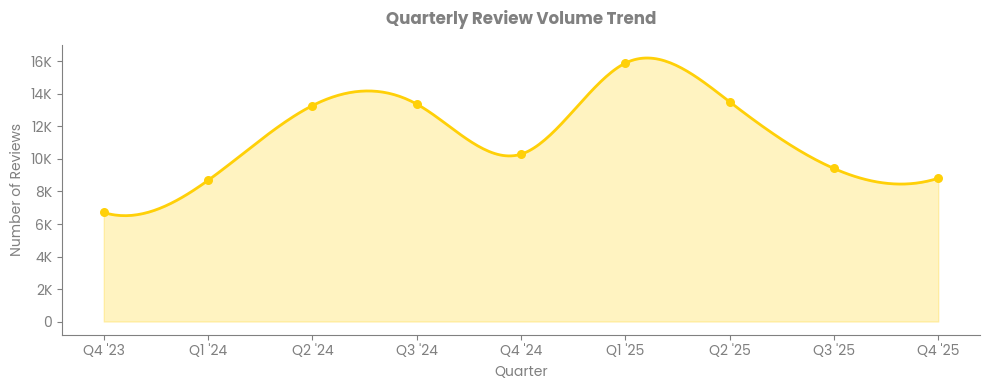

In [ ]:
x = np.arange(len(quarterly_volume))
y = quarterly_volume['Review_Count'].values

x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x_smooth, y_smooth, color='#ffd008', linewidth=2)
ax.fill_between(x_smooth, y_smooth, color='#ffd008', alpha=0.25)
ax.scatter(x, y, color='#ffd008', s=30, zorder=3)

ax.set_title('Quarterly Review Volume Trend', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of Reviews')
ax.set_xticks(x)
ax.set_xticklabels(quarterly_volume['X_Label'])
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
rating_stats = df['Rating'].describe()
print("\nRating Statistics:")
print(rating_stats)

# Rating distribution table
rating_dist = pd.DataFrame({
    'Count': df['Rating'].value_counts().sort_index(),
    'Percentage': (df['Rating'].value_counts(normalize=True).sort_index() * 100).round(2)
})
print("\nRating Distribution Table:")
display(rating_dist)

# Average rating per quarter
avg_rating_quarter = df.groupby('YearQuarter')['Rating'].mean().reset_index()
avg_rating_quarter['X_Label'] = ('Q' + avg_rating_quarter['YearQuarter'].dt.quarter.astype(str) +
                                  " '" + (avg_rating_quarter['YearQuarter'].dt.year % 100).astype(str).str.zfill(2))
print("\nAverage Rating per Quarter:")
display(avg_rating_quarter[['X_Label', 'Rating']].round(2))


Rating Statistics:
count    100000.000000
mean          2.520360
std           1.798916
min           1.000000
25%           1.000000
50%           1.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

Rating Distribution Table:


,Count,Percentage
Rating,,
1,53296,53.30
2,6774,6.77
3,5154,5.15
4,4150,4.15
5,30626,30.63



Average Rating per Quarter:


,X_Label,Rating
0,Q4 '23,3.71
1,Q1 '24,2.59
2,Q2 '24,2.98
3,Q3 '24,2.82
4,Q4 '24,2.92
5,Q1 '25,2.16
6,Q2 '25,1.98
7,Q3 '25,2.06
8,Q4 '25,1.91


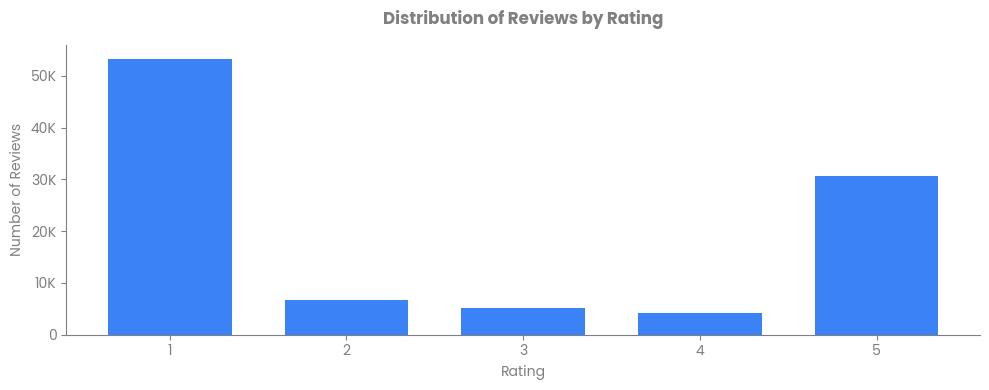

In [ ]:
rating_counts = (df['Rating'].value_counts().sort_index().reindex([1, 2, 3, 4, 5], fill_value=0))

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(rating_counts.index, rating_counts.values, color='#3b82f6', width=0.7)

ax.set_title('Distribution of Reviews by Rating', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Reviews')
ax.set_xticks([1, 2, 3, 4, 5])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

plt.tight_layout()
plt.show()

In [ ]:
# Sentiment distribution
sentiment_dist = pd.DataFrame({
    'Count': df['Sentiment'].value_counts(),
    'Percentage': (df['Sentiment'].value_counts(normalize=True) * 100).round(2)
})
print("Sentiment Distribution:")
display(sentiment_dist)

# Rating vs Sentiment cross-tab
rating_sentiment_crosstab = pd.crosstab(df['Rating'], df['Sentiment'], normalize='index') * 100
print("\nSentiment Distribution by Rating (%):")
display(rating_sentiment_crosstab.round(2))

# Quarterly sentiment percentage
quarterly_sentiment_pct = (df.groupby(['YearQuarter', 'Sentiment']).size().unstack(fill_value=0))
quarterly_sentiment_pct = (quarterly_sentiment_pct.div(quarterly_sentiment_pct.sum(axis=1), axis=0) * 100).round(2)
quarterly_sentiment_pct['X_Label'] = ('Q' + quarterly_sentiment_pct.index.to_series().dt.quarter.astype(str) +
                                       " '" + (quarterly_sentiment_pct.index.to_series().dt.year % 100).astype(str).str.zfill(2))
print("\nSentiment Distribution per Quarter (%):")
display(quarterly_sentiment_pct[['X_Label', 'Negative', 'Neutral', 'Positive']].reset_index(drop=True))

Sentiment Distribution:


,Count,Percentage
Sentiment,,
Negative,60070,60.07
Positive,34776,34.78
Neutral,5154,5.15



Sentiment Distribution by Rating (%):


Sentiment,Negative,Neutral,Positive
Rating,,,
1,100.0,0.0,0.0
2,100.0,0.0,0.0
3,0.0,100.0,0.0
4,0.0,0.0,100.0
5,0.0,0.0,100.0



Sentiment Distribution per Quarter (%):


Sentiment,X_Label,Negative,Neutral,Positive
0,Q4 '23,30.15,4.44,65.40
1,Q1 '24,57.65,6.40,35.95
2,Q2 '24,48.23,5.88,45.89
3,Q3 '24,52.52,4.75,42.74
4,Q4 '24,49.66,5.51,44.83
5,Q1 '25,69.14,5.69,25.17
6,Q2 '25,74.02,4.81,21.17
7,Q3 '25,72.01,4.66,23.32
8,Q4 '25,76.19,3.68,20.13


In [ ]:
print("MONTHLY TREND SUMMARY")

df['YearMonth'] = df['Tanggal'].dt.to_period('M')
monthly_stats = df.groupby('YearMonth').agg({
    'Rating': ['count', 'mean'],
    'Sentiment': lambda x: (x == 'Negative').sum()
}).round(2)
monthly_stats.columns = ['Review_Count', 'Avg_Rating', 'Negative_Count']
monthly_stats['Negative_Rate'] = (monthly_stats['Negative_Count'] / monthly_stats['Review_Count'] * 100).round(2)

print("\nLast 12 Months Statistics:")
display(monthly_stats.tail(12))

MONTHLY TREND SUMMARY

Last 12 Months Statistics:


,Review_Count,Avg_Rating,Negative_Count,Negative_Rate
YearMonth,,,,
2025-01,4484,2.56,2654,59.19
2025-02,4409,2.17,3037,68.88
2025-03,7004,1.90,5300,75.67
2025-04,4714,1.95,3529,74.86
2025-05,4098,2.06,2943,71.82
2025-06,4705,1.94,3533,75.09
2025-07,3613,2.06,2598,71.91
2025-08,2647,2.15,1842,69.59
2025-09,3155,1.99,2340,74.17


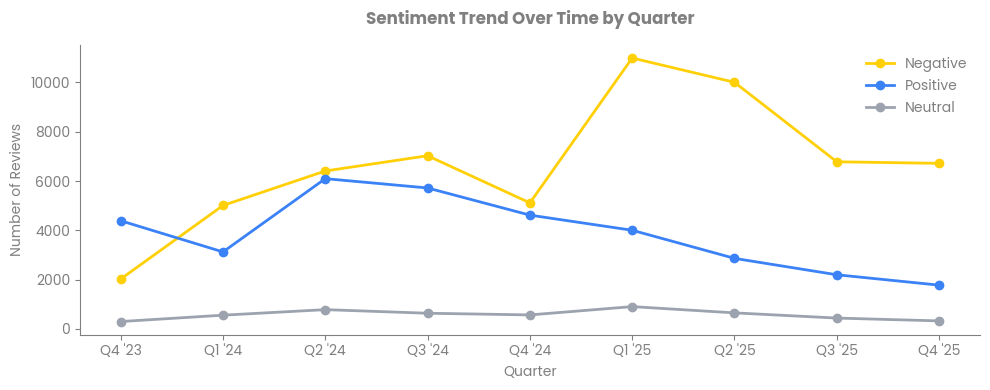

In [ ]:
quarterly_sentiment = (df.groupby(['YearQuarter', 'Sentiment']).size().unstack(fill_value=0).reset_index())

quarterly_sentiment['Q'] = quarterly_sentiment['YearQuarter'].dt.quarter
quarterly_sentiment['Y'] = quarterly_sentiment['YearQuarter'].dt.year % 100
quarterly_sentiment['X_Label'] = ('Q' + quarterly_sentiment['Q'].astype(str) +
                                   " '" + quarterly_sentiment['Y'].astype(str).str.zfill(2))

fig, ax = plt.subplots(figsize=(10, 4))

x = np.arange(len(quarterly_sentiment))
ax.plot(x, quarterly_sentiment['Negative'], marker='o', color='#ffd008', label='Negative', linewidth=2)
ax.plot(x, quarterly_sentiment['Positive'], marker='o', color='#3b82f6', label='Positive', linewidth=2)
ax.plot(x, quarterly_sentiment['Neutral'], marker='o', color='#9ca3af', label='Neutral', linewidth=2)

ax.set_title('Sentiment Trend Over Time by Quarter', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of Reviews')
ax.set_xticks(x)
ax.set_xticklabels(quarterly_sentiment['X_Label'])
ax.legend(frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## **3.3. Content Analysis**

Analyzes the structural characteristics of reviews, focusing on text length distributions across different ratings and sentiments. This section explores the relationship between review verbosity and user satisfaction, identifying correlations and patterns.

In [ ]:
# Overall statistics
print("Overall Text Length Statistics:")
print(df['Text_Length'].describe())

# By sentiment
print("\nText Length by Sentiment:")
display(df.groupby('Sentiment')['Text_Length'].describe().round(2))

# Length category distribution
length_dist = pd.DataFrame({
    'Count': df['Length_Category'].value_counts(),
    'Percentage': (df['Length_Category'].value_counts(normalize=True) * 100).round(2)
})
print("\nLength Category Distribution:")
display(length_dist)

Overall Text Length Statistics:
count    100000.000000
mean         11.234210
std          12.586957
min           1.000000
25%           3.000000
50%           7.000000
75%          15.000000
max         129.000000
Name: Text_Length, dtype: float64

Text Length by Sentiment:


,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
Negative,60070.0,14.36,13.21,1.0,5.0,10.0,19.0,106.0
Neutral,5154.0,14.12,13.67,1.0,5.0,10.0,19.0,106.0
Positive,34776.0,5.41,8.62,1.0,1.0,2.0,6.0,129.0



Length Category Distribution:


,Count,Percentage
Length_Category,,
Short,42646,42.65
Medium,33277,33.28
Long,24077,24.08


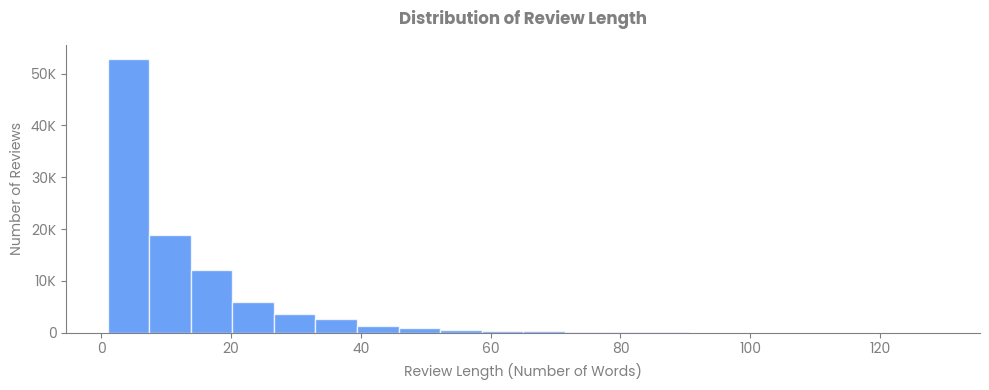

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(df['Text_Length'], bins=20, color='#3b82f6', alpha=0.75, edgecolor='white')

ax.set_title('Distribution of Review Length', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Review Length (Number of Words)')
ax.set_ylabel('Number of Reviews')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

plt.tight_layout()
plt.show()

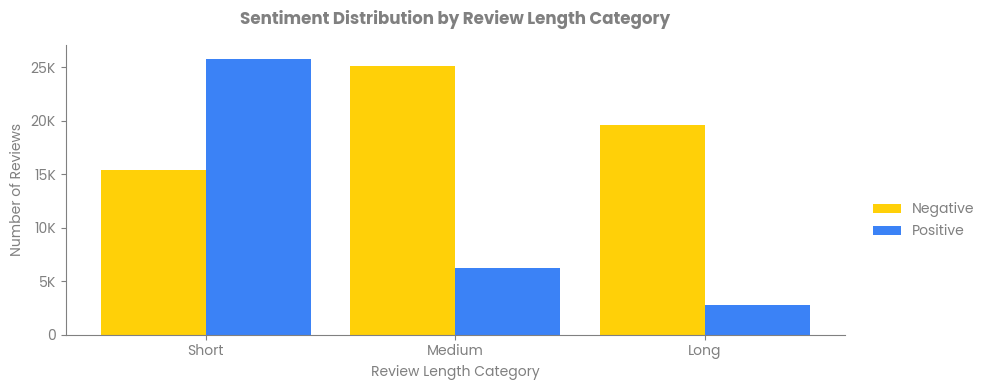

In [ ]:
filtered_df = df[df['Sentiment'].isin(['Positive', 'Negative'])]
summary = (filtered_df.groupby(['Length_Category', 'Sentiment']).size().unstack(fill_value=0).reindex(['Short', 'Medium', 'Long']))

x = np.arange(len(summary.index))
width = 0.42

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(x - width/2, summary['Negative'], width, label='Negative', color='#ffd008')
ax.bar(x + width/2, summary['Positive'], width, label='Positive', color='#3b82f6')

ax.set_title('Sentiment Distribution by Review Length Category', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Review Length Category')
ax.set_ylabel('Number of Reviews')

ax.set_xticks(x)
ax.set_xticklabels(summary.index)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 0.5))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

plt.tight_layout()
plt.show()

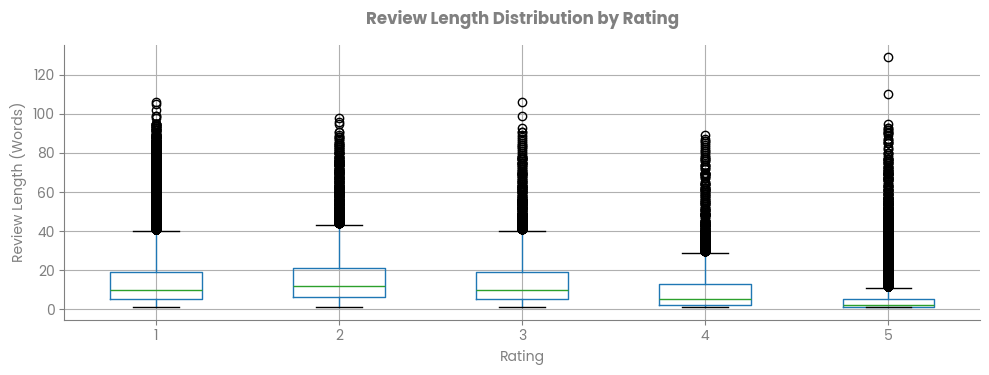


Average Text Length by Rating:
             mean  median        std
Rating                              
1       14.111340    10.0  13.058414
2       16.293918    12.0  14.236947
3       14.121459    10.0  13.674901
4        9.814217     5.0  12.735303
5        4.814765     2.0   7.703989


In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df.boxplot(column='Text_Length', by='Rating', ax=ax)

ax.set_title('Review Length Distribution by Rating', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Rating')
ax.set_ylabel('Review Length (Words)')
ax.get_figure().suptitle('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nAverage Text Length by Rating:")
print(df.groupby('Rating')['Text_Length'].agg(['mean', 'median', 'std']))

In [ ]:
print("CORRELATION ANALYSIS")

correlation = df['Rating'].corr(df['Text_Length'])
print(f"\nCorrelation between Rating and Text Length: {correlation:.4f}")

contingency_table = pd.crosstab(df['Rating'], df['Sentiment'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square Test (Rating vs Sentiment):")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Degrees of freedom: {dof}")

CORRELATION ANALYSIS

Correlation between Rating and Text Length: -0.3268

Chi-square Test (Rating vs Sentiment):
  Chi-square statistic: 200000.0000
  p-value: 0.000000
  Degrees of freedom: 8


## **3.4. Keyword & Topic Analysis**

Performs linguistic analysis to identify dominant themes and frequently mentioned topics within reviews. Using text preprocessing, stopword removal, and n-gram extraction, this section uncovers key concerns and praise points from users across different sentiment categories.

In [ ]:
stop_words_id = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'untuk', 'pada', 'adalah', 'dengan', 'ini', 'itu', 'di', 'ke', 'dari', 'akan', 'oleh', 'saya', 'kamu', 'kami', 'mereka', 'nya', 'mu', 'ku',  'tidak', 'bisa', 'dapat', 'sudah', 'belum', 'ada', 'gak', 'ga', 'ngga', 'pengguna', 'google', 'app', 'aplikasi', 'telegram', 'aja', 'saja', 'aja', 'saja', 'udah', 'sudah', 'banget', 'bgt', 'very', 'tolong', 'sih', 'dong', 'kan', 'nya', 'tele', 'telegram', 'apk', 'app', 'apps', 'aplikasi', 'aplikasinya', 'yg', 'yang', 'ga', 'gak', 'gk', 'enggak', 'sy', 'saya', 'aku', 'kalo', 'klo', 'ini', 'itu', 'the', 'gimana', 'pake', 'orang', 'kasih', 'makasih', 'terima',  'bintang', 'star', 'perbaiki', 'fix', 'betulin', 'kirim', 'ngirim', 'bikin', 'buat',  'coba', 'mencoba',  'muncul', 'tampil', 'menerima', 'diterima',  'dikirim', 'ngirim', 'kirim', 'buka', 'dibuka',  'masukin', 'memasukkan', 'dapet', 'dapat',  'pake', 'pakai',  'nunggu', 'menunggu', 'diperbaiki', 'perbaiki', 'pas', 'saat',  'kali', 'sekali',  'tetep', 'tetap',  'udh', 'udah', 'sudah',  'bener', 'benar', 'verry', 'very', 'gua', 'gue', 'gw', 'saya', 'aku',  'orang', 'teman',  'log',  'mohon', 'tolong',  'semoga', 'moga',  'terimakasih', 'makasih', 'thanks'}
stop_words_id.update(custom_stopwords)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['Ulasan'].apply(clean_text)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words_id and len(word) > 2]
    return ' '.join(filtered_words)

df['filtered_text'] = df['cleaned_text'].apply(remove_stopwords)

negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['filtered_text'].dropna())
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['filtered_text'].dropna())
neutral_text = ' '.join(df[df['Sentiment'] == 'Neutral']['filtered_text'].dropna())

In [ ]:
# Top unigrams for each sentiment
def get_top_words(text_series, top_n=20):
    words = ' '.join(text_series).split()
    return Counter(words).most_common(top_n)

print("Top 20 Words - Positive Reviews:")
pos_top_words = get_top_words(df[df['Sentiment'] == 'Positive']['filtered_text'].dropna(), 20)
pos_words_df = pd.DataFrame(pos_top_words, columns=['Word', 'Frequency'])
display(pos_words_df)

print("\nTop 20 Words - Negative Reviews:")
neg_top_words = get_top_words(df[df['Sentiment'] == 'Negative']['filtered_text'].dropna(), 20)
neg_words_df = pd.DataFrame(neg_top_words, columns=['Word', 'Frequency'])
display(neg_words_df)

print("\nTop 20 Words - Neutral Reviews:")
neu_top_words = get_top_words(df[df['Sentiment'] == 'Neutral']['filtered_text'].dropna(), 20)
neu_words_df = pd.DataFrame(neu_top_words, columns=['Word', 'Frequency'])
display(neu_words_df)

Top 20 Words - Positive Reviews:


,Word,Frequency
0,bagus,6755
1,good,4767
2,mantap,2115
3,membantu,1287
4,suka,969
5,kode,954
6,keren,840
7,akun,804
8,masuk,803
9,login,756



Top 20 Words - Negative Reviews:


,Word,Frequency
0,kode,16911
1,login,15472
2,masuk,10254
3,akun,7439
4,sms,7175
5,verifikasi,6424
6,susah,5972
7,nomor,5604
8,premium,5055
9,daftar,4399



Top 20 Words - Neutral Reviews:


,Word,Frequency
0,kode,859
1,masuk,721
2,login,720
3,akun,578
4,bagus,567
5,susah,422
6,premium,396
7,sms,337
8,nomor,320
9,download,318


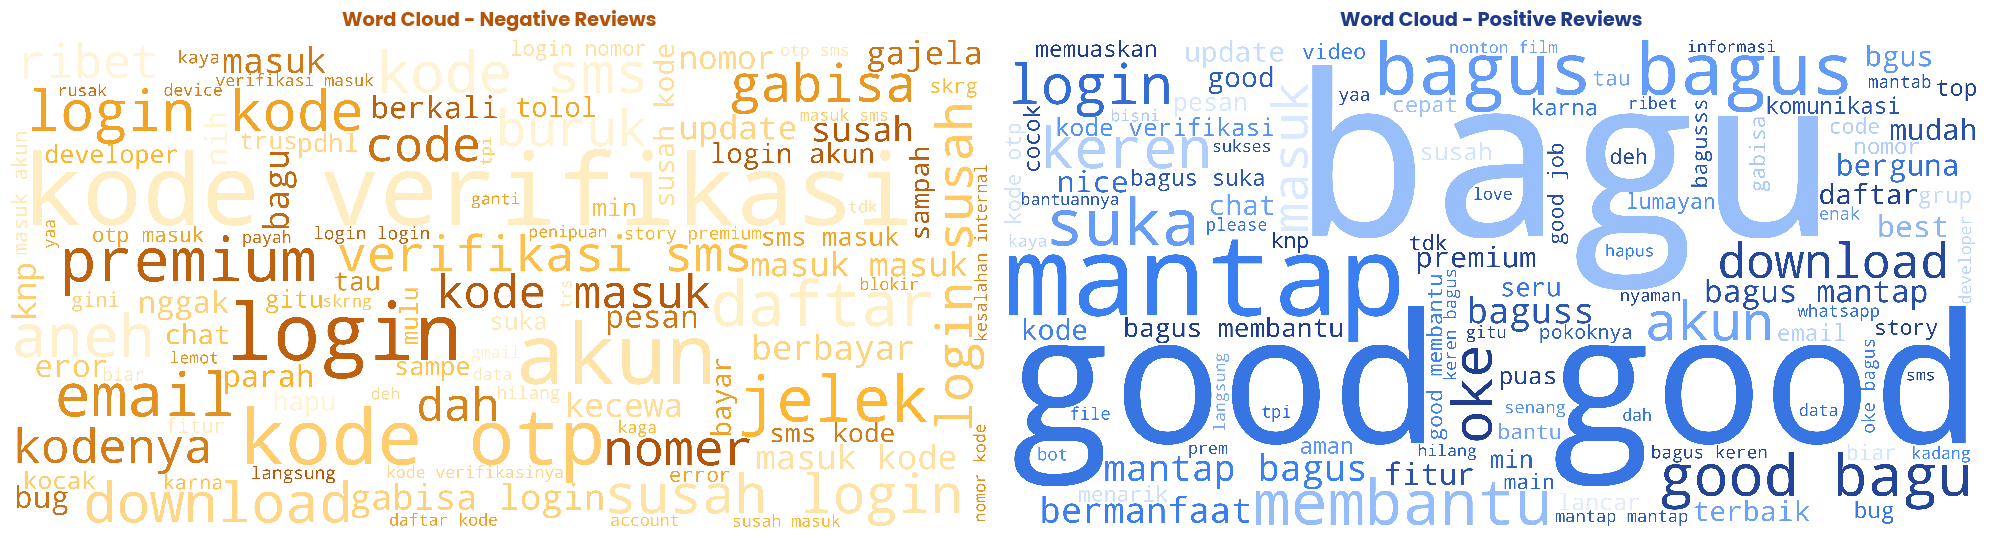

In [ ]:
neg_cmap = LinearSegmentedColormap.from_list("custom_orange", ["#fff4d6", "#ffb52d", "#b45309"])
pos_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#e0edff", "#3b82f6", "#1e3a8a"])

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

wc_neg = WordCloud(width=1600, height=800, scale=3, background_color=None, mode="RGBA", max_words=100, min_font_size=12, colormap=neg_cmap).generate(negative_text)
wc_pos = WordCloud(width=1600, height=800, scale=3, background_color=None, mode="RGBA", max_words=100, min_font_size=12, colormap=pos_cmap).generate(positive_text)
axes[0].imshow(wc_neg, interpolation="nearest")  # JANGAN bilinear
axes[0].axis("off")
axes[0].set_title('Word Cloud - Negative Reviews', fontsize=14, fontweight='bold', pad=10, color='#b45309')

axes[1].imshow(wc_pos, interpolation="nearest")
axes[1].axis("off")
axes[1].set_title('Word Cloud - Positive Reviews', fontsize=14, fontweight='bold', pad=10, color='#1e3a8a')

plt.tight_layout()
plt.show()

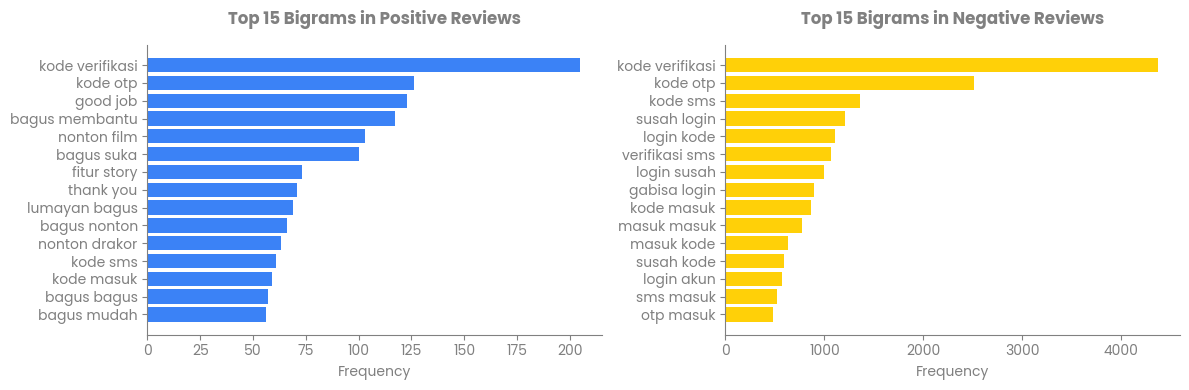

In [ ]:
def get_top_ngrams(corpus, n=2, top_k=15):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=5000)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Bigrams untuk Positive & Negative
positive_bigrams = get_top_ngrams(df[df['Sentiment'] == 'Positive']['filtered_text'].dropna(), n=2, top_k=15)
negative_bigrams = get_top_ngrams(df[df['Sentiment'] == 'Negative']['filtered_text'].dropna(), n=2, top_k=15)

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Positive Bigrams
pos_words, pos_counts = zip(*positive_bigrams)
axes[0].barh(pos_words, pos_counts, color='#3b82f6')
axes[0].set_title('Top 15 Bigrams in Positive Reviews', fontsize=12, fontweight='bold', pad=15)
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Negative Bigrams
neg_words, neg_counts = zip(*negative_bigrams)
axes[1].barh(neg_words, neg_counts, color='#ffd008')
axes[1].set_title('Top 15 Bigrams in Negative Reviews', fontsize=12, fontweight='bold', pad=15)
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()